# Working with __processed__ immune repertoire sequencing data using `R`

-----

## __Overview:__

We will be using `tidyverse` and `Bioconductor` to work with __pre-processed__ immune repertoire sequencing data in `R`.
You have already learned about both of these collections of packages, and today's class will give you the opportunity to practice using them in a new biological context.

#### __Goals for class:__
1. Familiarize with the format of __processed__ immune repertoire sequencing data
2. Work through an example analysis, and practice on your own

#### __Sidenote:__
We will not be discussing methods for processing __raw__ immune repertoire sequencing data. If you are interested in this, I encourage you to check out the following packages (most of which can be run on the command line):

- [MiXCR](https://mixcr-cn.readthedocs.io/en/latest/index.html): a standard package for processing raw immune repertoire sequencing data and producing basic sequence annotations
- [TRUST4](https://github.com/liulab-dfci/TRUST4): another package option for processing raw immune repertoire sequencing data and producing basic sequence annotations
- [IGoR](https://qmarcou.github.io/IGoR/): a package for probabilistic immune repertoire sequence annotation and simulation
- there are many more out there...

----

## __Load packages__

In [143]:
library(Biostrings)
library(tidyverse)

## __Loading example datasets__

In [124]:
indiv1 <- read.csv('https://drive.google.com/uc?id=1b1oXlhg99_YCPK_HzFL2ohYPDxvTbQOo', sep = '\t', header = TRUE)
indiv2 <- read.csv('https://drive.google.com/uc?id=10qMY16H9wD_wuC4ISAJRTRx_bOeclg5D', sep = '\t', header = TRUE)

Let's take a look at the data. 
Recall that each annotated TCRB sequence takes the form:

5'-[__V gene__]-(_possible V gene deletion_)-[__V-D insertion__]-(_possible D gene deletion_)-[__D gene__]-(_possible D gene deletion_)-[__D-J insertion__]-(_possible J gene deletion_)-[__J gene__]-3'

Using the column names given by the file, we can interpret this as:

5'-[__`v_gene`__]-(_`v_trim`_)-[__`vd_insert_nucs`__]-(_`d5_trim`_)-[__`d_gene`__]-(_`d3_trim`_)-[__`dj_insert_nucs`__]-(_`j_trim`_)-[__`j_gene`__]-3'

Here is a summary of what each column shows:

* `cdr3_nucseq`: nucleic acid sequence of the CDR3 region of the receptor sequence
* `cdr3`: amino acid sequence of the CDR3 region of the receptor sequence
* `v_gene`: identity of the V-gene used in the receptor sequence
* `d_gene`: identity of the D-gene used in the receptor sequence
* `j_gene`: identity of the J-gene used in the receptor sequence
* `v_trim`: number of nucleotides deleted from the 3' end of the V-gene in the receptor sequence
* `d5_trim`: number of nucleotides deleted from the 5' end of the D-gene in the receptor sequence
* `d3_trim`: number of nucleotides deleted from the 3' end of the D-gene in the receptor seque
* `j_trim`: number of nucleotides deleted from the 5' end of the J-gene in the receptor seque
* `vd_insert`: number of nucleotides inserted between the V- and the D-gene in the receptor sequence
* `dj_insert`: number of nucleotides inserted between the D- and the J-gene in the receptor sequence
* `vd_insert_nucs`: sequence of nucleotides inserted between the V- and the D-gene in the receptor sequence
* `dj_insert_nucs`: sequence of nucleotides inserted between the D- and the J-gene in the receptor sequence
* `productive`: whether the sequence can be translated into a receptor protein sequence

In [125]:
head(indiv2)

,seq_index,cdr3_nucseq,cdr3,v_gene,d_gene,j_gene,v_trim,d5_trim,d3_trim,j_trim,vd_insert,dj_insert,vd_insert_nucs,dj_insert_nucs,productive
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<lgl>
1,0,TGTGCCAGTAGTATTTTACAATGAGCAGTTCTTC,,TRBV19*01,TRBD1*01,TRBJ2-1*01,3,0,12,4,0,2,,TT,FALSE
2,1,TGTGCCAGCAGCTTGAATCACGAGCAGTACTTC,CASSLNHEQYF,TRBV5-6*01,TRBD2*02,TRBJ2-7*01,1,3,13,5,4,0,AATC,,TRUE
3,2,TGCGCCAGCAGCTTGGCAGAGACCCAGTACTTC,CASSLAETQYF,TRBV5-1*01,TRBD1*01,TRBJ2-5*01,2,9,0,4,0,0,,,TRUE
4,3,TGTGCCAGCAGGTGGCAATCAGCCCCAGCATTTT,,TRBV7-9*01,TRBD2*02,TRBJ1-5*01,7,10,4,2,0,2,,GT,FALSE
5,4,TGTGCCAGCAGCCTGAGCTTTCTTT,,TRBV3-2*01,TRBD2*02,TRBJ1-1*01,4,14,1,11,1,1,T,A,FALSE
6,5,TGTGCCAGCAGGTGTATTTT,,TRBV12-3*01,TRBD2*02,TRBJ1-3*01,6,1,14,16,2,0,GT,,FALSE


## Example analyses __exploring recombination statistics__ using `tidyverse` and `Bioconductor`

#### Find __which V-gene occurs most frequently__ for individual 2 using `tidyverse`

In [145]:
indiv2 %>%
    group_by(v_gene) %>%
    summarise(total_count = n()) %>%
    arrange(desc(total_count)) %>%
    head()

v_gene,total_count
<chr>,<int>
TRBV20-1*01,7510
TRBV30*01,3846
TRBV19*01,3358
TRBV6-5*01,3271
TRBV9*01,2999
TRBV18*01,2879


#### Calculate __V-D N-insertion composition frequencies__ within individual 2 using `Bioconductor`

In [127]:
# filter for sequences that have VD N-inserts
n_indiv2 <- indiv2 %>%
                filter(vd_insert != 0)

In [128]:
# convert VD N-insert column to a BioStrings `DNAStringSet`
nucs_indiv2 <- DNAStringSet(n_indiv2$vd_insert_nucs)

nucs_indiv2

DNAStringSet object of length 63505:
        width seq
    [1]     4 AATC
    [2]     1 T
    [3]     2 GT
    [4]     3 CGG
    [5]     2 TA
    ...   ... ...
[63501]    11 CTACAACTTAA
[63502]     5 TCCAA
[63503]     6 GGTGCG
[63504]     7 CCGTCGG
[63505]     5 CCCCC

In [129]:
# get frequencies
nucs_freq2 <- nucs_indiv2 %>%
              letterFrequency(c("A", "T", "C", "G"), collapse = TRUE, as.prob = TRUE)

print(nucs_freq2)

        A         T         C         G 
0.2036577 0.2102730 0.3316450 0.2544242 


In [130]:
# convert frequencies to data.frame
nucs_freq2_df <- data.frame(base = names(nucs_freq2), frequency = nucs_freq2, row.names = NULL)

nucs_freq2_df

base,frequency
<chr>,<dbl>
A,0.2036577
T,0.2102730
C,0.3316450
G,0.2544242


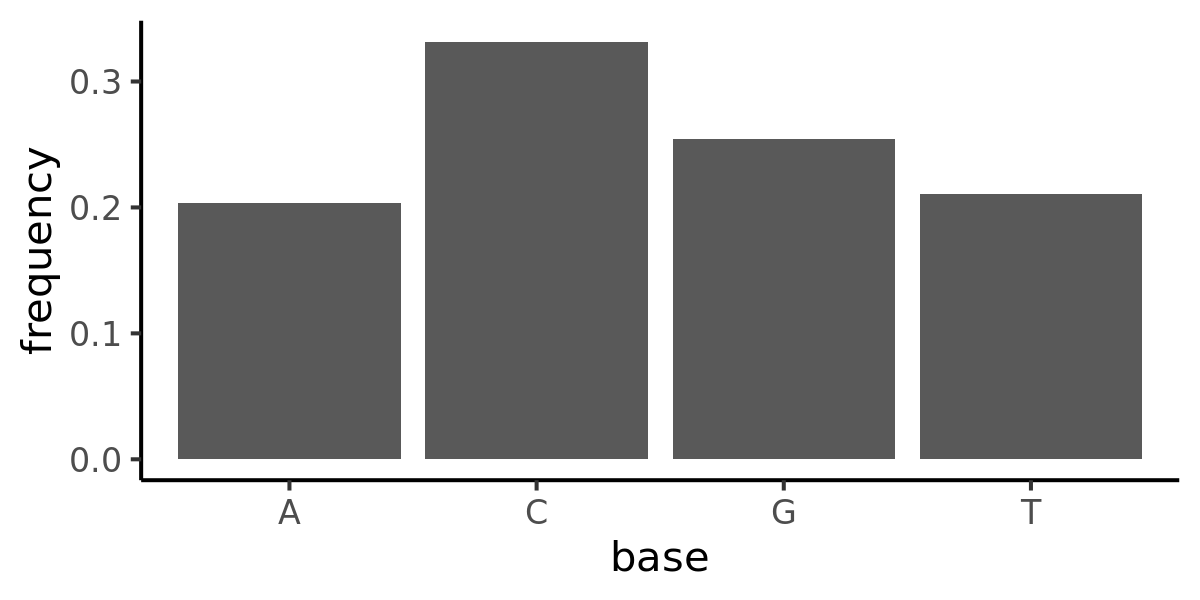

In [131]:
# plot frequencies
options(repr.plot.width = 10, repr.plot.height = 5)

nucs_freq2_df %>%
    ggplot(aes(x = base, y = frequency)) +
    geom_bar(stat = 'identity') +
    theme_classic(base_size = 25)

# __In-class exercises__

(30-40 minutes)

### __Problem 1:__ Calculate the N-insertion base frequencies for each N-insertion junction (combining data from both individuals) and plot them in a grouped barplot. Are they similar?

I have made a code chunk for each step

In [132]:
# combine data from both individuals (hint: use `rbind` to join dataframes)


In [133]:
# calculate frequencies of VD and DJ N-insertion nucleotides separately
## hint: make sure to convert frequencies into dataframes like we did above
## hint 2: you will want to add a new column to each dataframe to specify the junction (i.e. "VD" or "DJ")


In [134]:
# combine frequency dataframes (hint: you'll want to use `rbind` again)


In [135]:
# plot grouped barplot
## hint: to make a grouped barplot, you'll need to specify a fill/color aesthetic and specify `position = "dodge"` within the `geom_bar`` function


### __Problem 2:__ Find the rearrangement/s (`cdr3` column) which has the largest overlap between the two individuals.

Again, I have made a code chunk for each step


In [136]:
# find the cdr3 (amino acid) counts for each individual seperately


In [137]:
# merge count dataframes from both individuals
## Hint: this merged dataframe should have three columns: cdr3 AA sequence, count for individual 1, and count for individual 2



In [138]:
# calculate the cdr3 overlap between the two individuals
## i.e. for each sequence, the minimum count between the two individuals
## Hint: you may find the `pmin` function to be useful...



In [139]:
# find the cdr3 sequence/s that have the largest overlap, and filter the overlap dataframe accordingly


### __Challenge:__ Pick one of the largest overlap rearrangements--which nucleotide rearrangment most commonly leads to that CDR3 amino acid sequence for each individual?

Again, I've provided a code chunk for each step

In [140]:
# choose one of the max overlap cdr3 amino acid sequences     


In [141]:
# for each individual, find the NT rearrangment that most commonly gives rise to the AA sequence


In [142]:
# determine whether these sequences the same between the two individuals
